
### Datasets

* The [QSAR](http://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation) data for predicting the biochemical activity of a molecule.
* The [Wisconsin breast cancer wisconsin dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def load_qsar():
    X = pd.read_csv('biodeg.csv', delimiter=';', usecols=range(0,41)).values
    y = pd.read_csv('biodeg.csv', delimiter=';', usecols=range(41,42)).values
    
    #change RB to 1 for biodegradable and NRB to -1 for non-biodegradable
    y[y == 'RB'] = 1
    y[y == 'NRB'] = -1
    
    return X,y.astype(int).flatten()

def load_breast_cancer():
    from sklearn.datasets import load_breast_cancer
    X,y = data = load_breast_cancer(return_X_y=True)
    
    #Changing 0s to -1
    y[y == 0] = -1
    
    return X,y

## Part 1:  choosing optimal hyperparameters

Just about any machine learning algorithm has some **hyperparameters**.  These are parameters that are set by the user and are not determined as part of the training process.
The perceptron for example, has two of those - the number of epochs and the learning rate.  For the k-nearest neighbor classifier (kNN) it's the number of neighbors, $k$, and for the linear SVM it's the soft margin constant, $C$.  Our objective in machine learning is to obtain classifiers with high accuracy, and have good estimates of how well they are performing.  In other words, we need to know how accurate a classifier would be on unseen data.  This is why we use separate test sets that the classifier has not seen for evaluating accuracy.

When working with classifiers with hyperparameters you may be tempted to apply the following procedure:

* Randomly split the data into separate train and test sets.
* Loop over a list of candidate values for the hyperparameter.
* For each value, train the classifier over the training set and evaluate its performance on the test set.
* Choose the parameter value that maximizes the accuracy over the test set, and report the accuracy that you obtained.

However, it turns out that this procedure is flawed, and the resulting accuracy estimate can be overly optimistic.  This is because the choice of the best performing parameter value used information about the test set: by selecting the best value according to performance on the test set, we use information about the labels of the test set.  Therefore, the predicted labels are based on information regarding the labels of the test set, making it so this is no longer an independent test set.

Here is a better approach.  Rather than splitting the data into train and test sets, we will now split the data into three sets:  **training, validation, and test**.  The validation set will be used for evaluation of different values of the hyperparameter, leading to the following approach:

* Randomly split the data into separate train, validation, and test sets (say with ratios of 0.5, 0.2, 0.3).
* Loop over a list of candidate values for the hyperparameter.
* For each value, train the classifier over the **training set** and evaluate its performance on the **validation set**. 
* Choose the best classifier, and report its accuracy over the **test set**.

Your task is as follows:

* Use the method described above to evaluate the performance of the kNN classifier over the QSAR and Wisconsin breast cancer dataset.  Use a wide range of $k$ values.  Repeat the process ten times over different train/test splits and report the average accuracy over the test set.  What value of $k$ was chosen most often?  Note that the optimal value of $k$ may vary for different splits.  Comment on your results.

* Perform the same experiment for the linear SVM. In this case the soft-margin constant $C$ is the hyperparameter that requires an informed choice.  Use a wide range of values for $C$, as we have done in class.  Comment on your results.

In your code, use the scikit-learn kNN and SVM implementations; you can also use the scikit-learn `train_test_split`.  When using scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) class, make sure to provide the parameter `kernel="linear"` so that the the resulting SVM is indeed linear; alternatively, use the [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) class.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [4]:
k_parameters = [1,3,5,10,15,25,30]
c_parameters = [0.001,0.01, 0.1, 1, 10, 100, 1000]
X_qsar, y_qsar = load_qsar()
X_breast, y_breast = load_breast_cancer()

def classifiers(X, y, classifier_class, paramater_array):
    accuracy_list = []
    chosen_parameter_list = []
    
    for i in range(10):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.375)
        
        highest = 0
        for p in paramater_array:
            classifier = classifier_class(kernel="linear", C=p) if classifier_class == SVC else classifier_class(p)
            classifier.fit(X_train, y_train)
            y_temp = classifier.predict(X_val)
            curr_accuracy = np.mean(y_val == y_temp) if classifier_class == SVC else np.sum(y_temp == y_val)/len(y_val)
            
            if curr_accuracy > highest: 
                highest = curr_accuracy
                curr_parameter = p
        
        chosen_parameter_list.append(curr_parameter)
        classifier = classifier_class(kernel="linear", C=curr_parameter) if classifier_class == SVC else classifier_class(p)
        classifier.fit(X_train, y_train)
        y_temp = classifier.predict(X_test)
        curr_accuracy = np.mean(y_test == y_temp) if classifier_class == SVC else np.sum(y_temp == y_test)/len(y_test)
        accuracy_list.append(curr_accuracy)
    
    return (accuracy_list, chosen_parameter_list)

k_qsar_accuracy, k_qsar_parameter = classifiers(X_qsar, y_qsar, KNeighborsClassifier, k_parameters)
svc_qsar_accuracy, svc_qsar_parameter = classifiers(X_qsar, y_qsar, SVC, c_parameters)
k_breast_accuracy, k_breast_parameter = classifiers(X_breast, y_breast, KNeighborsClassifier, k_parameters)
svc_breast_accuracy, svc_breast_parameter = classifiers(X_breast, y_breast, SVC, c_parameters)

In [5]:
import statistics
df = [
    ['kNN (QSAR)', statistics.mode(k_qsar_parameter), np.mean(k_qsar_accuracy)],
    ['SVM (QSAR)', statistics.mode(svc_qsar_parameter), np.mean(svc_qsar_accuracy)],
    ['kNN (Breast)', statistics.mode(k_breast_parameter), np.mean(k_breast_accuracy)],
    ['SVM (Breast)', statistics.mode(svc_breast_parameter), np.mean(svc_breast_accuracy)],
]

print(f'kNN (QSAR): {sorted(k_qsar_parameter)}')
print(f'SVC (QSAR): {sorted(svc_qsar_parameter)}')
print(f'kNN (Breast): {sorted(k_breast_parameter)}')
print(f'SVC (Breast): {sorted(svc_breast_parameter)}')
pd.DataFrame(df, columns=['Classifier', 'Parameter most chosen', 'Mean of Accuracy over 10 Classifications'])

kNN (QSAR): [1, 3, 3, 3, 3, 5, 10, 10, 10, 15]
SVC (QSAR): [0.1, 0.1, 1, 1, 1, 1, 1, 1, 10, 100]
kNN (Breast): [1, 1, 1, 1, 5, 5, 10, 10, 15, 15]
SVC (Breast): [0.001, 0.01, 0.1, 1, 10, 10, 10, 10, 100, 1000]


,Classifier,Parameter most chosen,Mean of Accuracy over 10 Classifications
0,kNN (QSAR),3,0.758991
1,SVM (QSAR),1,0.853312
2,kNN (Breast),1,0.925146
3,SVM (Breast),10,0.937427


**In the table above, you can see the results of the two classifiers on the two datasets. For the k-Nearest-Neighbors classifier, the parameter, k, that was the most frequently chosen to use in the test set was 3. For the breast cancer dataset, it was a 1. With multiple attempts, the most common calssifiers tended to be within 1, 3, 5, and 10. The original list of test k values had 25, and 30 as well, but those are not included in the most chosen list. This is because a high parameter underfits the data leads to unclear decision boundary. The same is true for the SVC clasifier. The most frequent parameters were 0.1, 1, or 10. Smaller values such as 0.001 and larger values such as 1000 were rare because of being influenced by noise and overfitting the data, respectively. Generally, you can see that the SVM is a better classifier than the kNN because of the higher accuracies produced for both dataset. Finding the best hyperparameter allows us to take advantage of the classifier and get better results.**

## Part 2:  PCA for removing noise from data

As we have seen in class, performance of the nearest neighbor classifer degrades when the data has noisy features that are not relevant to the classification problem.  To remedy this problem, we will use PCA to reduce the dimensionality of the data.

Here is what you need to do:

* **Classifier performance with and without noise**.  Use the QSAR dataset and evaluate performance of K nearest neighbors and SVM.  For simplicity, choose the values of K and $C$ that you selected in part 1.  Also, we need to know whether the data should be standardized or not, so compare performance for standardized / non-standardized data.  Next, add 2000 noise features and evaluate model performance after doing so (use the better performing dataset between standardized / non-standardized dataset as your starting point).
* **Can PCA improve performance on noisy data?**  Next, we will see if PCA can improve the performance of the classifier on the data we added noise to.  Use PCA to represent the noise-added data in the space of the principal components.  Make sure the data is centered or standardized before applying PCA (Recall that centering refers to subtracting the mean from each feature, making it so that each feature has a mean of 0).  Evaluate the performance of the KNN and SVM classifiers as you vary the number of principal components (no need to go above the original dimensionality of the dataset when doing so).  Plot the accuracy of each classifier on the test set as you vary the number of components.
* **Discussion**.  Discuss your results:  was PCA useful for improving classifier performance?  Which of the two classifiers appears to be more robust to noise?  Why do you think that is the case?


In [33]:
# your code
from numpy.random import default_rng
rng = default_rng(1)

def standardize(X):
    mean_X = np.mean(X, axis=0)
    std_X = np.std(X, axis=0)
    
    X_standard = X - mean_X
    X_standard = X_standard / std_X
    
    return X_standard

def calculate_accuracy(X, y, classifier_class, parameter, noise=0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if noise == 0: pass
    else:
        X_train = np.hstack((X_train, rng.normal(0,0.5,size=(len(X_train), noise))))
        X_test = np.hstack((X_test, rng.normal(0,0.5, size=(len(X_test), noise))))
    
    classifier = classifier_class(kernel="linear", C=parameter) if classifier_class == SVC else classifier_class(parameter)
    classifier.fit(X_train, y_train)
    y_val = classifier.predict(X_test)
    curr_accuracy = np.mean(y_test == y_val) if classifier_class == SVC else np.sum(y_val == y_test)/len(y_test)
    
    return (curr_accuracy)

X_qsar, y_qsar = load_qsar()
X_qsar_standardized = standardize(X_qsar)

k_nstandard = calculate_accuracy(X_qsar, y_qsar, KNeighborsClassifier, 3)
svc_nstandard = calculate_accuracy(X_qsar, y_qsar, SVC, 1)
k_standard = calculate_accuracy(X_qsar_standardized, y_qsar, KNeighborsClassifier, 3)
svc_standard = calculate_accuracy(X_qsar_standardized, y_qsar, SVC, 1)
k_noise = calculate_accuracy(X_qsar_standardized, y_qsar, KNeighborsClassifier, 3, 2000)
svc_noise = calculate_accuracy(X_qsar_standardized, y_qsar, SVC, 1, 2000)

df = [
    ['Standard', k_standard, svc_standard],
    ['Non-standard', k_nstandard, svc_nstandard],
    ['With 2000 Noise', k_noise, svc_noise],
]
pd.DataFrame(df, columns=['Dataset', 'kNNn', 'SVC'])

,Dataset,kNNn,SVC
0,Standard,0.832808,0.905363
1,Non-standard,0.807571,0.851735
2,With 2000 Noise,0.690852,0.753943


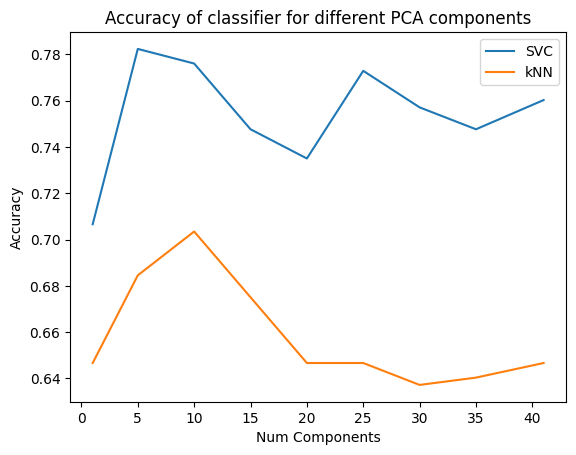

In [34]:
from sklearn.decomposition import PCA
X_with_noise = np.hstack((X_qsar_standardized, rng.normal(0,0.5,size=(len(X_qsar_standardized), 2000))))
X_with_noise_standard = standardize(X_with_noise)

num_components = [1,5,10,15,20,25,30,35,41]
svc_noise_accuracy = []
k_noise_accuracy = []

for n in num_components:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_with_noise_standard)
    
    svc_noise_accuracy.append(calculate_accuracy(X_pca, y_qsar, SVC, 1))
    k_noise_accuracy.append(calculate_accuracy(X_pca, y_qsar, KNeighborsClassifier, 3))
    
plt.plot(num_components, svc_noise_accuracy, label="SVC")
plt.plot(num_components, k_noise_accuracy, label="kNN")
plt.xlabel("Num Components")
plt.ylabel("Accuracy")
plt.title("Accuracy of classifier for different PCA components")
plt.legend()

**In the first cell, I compared the standard and nonstandard data with the parameter values I got from part 1, which were 3 for kNN and 0.10 for SVC. I saw that the standardized datset had a higher accuracy, so I used that for the next part. After adding 2000 noise features to the standard dataset, both classifier were evidently worse at classifications after the noise features. In the second cell, I took the dataset with the 2000 noise variable and standardized it. Thereafter, both classifiers were tested on how well they performed for various components of PCA until the orginal number of features, which was 41. In the graph above, it is noticeable that the accuracy using the kNN classifier does increase slightly for the first few components, but it is even lower after that. For the SVC classifier, most of the accuracies are above what we got by just using the dataset with 2000 noise features. However, both classifiers performed well below the dataset without any noise, standard and non-standard. I think the PCA was helpful for only the first few components as the accuray for both classifier dropped after that. PCA can help reduce dimensionality but it can still capture some of the noise; this is the reason why none of the accuracy is close to the original dataset without any noise added. The kNN classifier is definitely more strongly affected by noise. This can be noticed in the graph above as the pca analysis did not help increase the accuracy for most components. In contrast, the pca did help the svc, which indicates that noise isn't as influential for the svc.**

### Code organization

Both tasks in this assignment require you to run a particular experiment over multiple classifiers, datasets, or pre-processing steps.  In writing your code refrain from repeating the code over and over again.  To achieve that, decompose the task such that your code is modular and concise.  Not only will your code be more readable and elegant, this will also enable you to be more productive.

### Your Report

Answer the questions in the cells reserved for that purpose.

### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots in your notebook.

### Grading 

```
Grading sheet for assignment 3

Part 1:  5 points
Model selection code for SVM/KNN (4 pts)
Discussion of your results (0.5 pt)
Code organization (0.5 pt)
Part 2:  5 points
Baseline SVM/KNN performance (1 pt)
SVM/KNN performance as a function of number of PCs (2.5 pts)
Discussion of your results (1 pt)
Code organization (0.5 pt)
```

Grading should be based on the following criteria:

  * Code correctness.
  * Plots and other results are well formatted and easy to understand.
  * Interesting and meaningful observations made where requested.
  * Notebook is readable, well-organized, and concise.
  
